## Skin Cancer Classification | Transfer Learning | XAI

#### Load image dataset


This python files set the path for the folders where train and test images are stored, inspect the data (i.e. number of images), create dataframe using path to each image and theor labels.

In [ ]:
pip install scikit-plot tensorflow-hub tensorflow_addons -q vit-keras tf-keras-vis lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Import required packages
import os
import glob
import random
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from vit_keras import vit
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from skimage.transform import resize

from lime import lime_image
from skimage.segmentation import mark_boundaries
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# In case running with Google colab mount the drive to access the dataset uploaded on drive (If running in local no need to run this step)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to dataset - data is stored in folder named data/train and data/test
# In case running on local system, you can define path to the folder where data is stored
path_train = '/content/drive/MyDrive/Colab Notebooks/8013/data/train/'
path_test = '/content/drive/MyDrive/Colab Notebooks/8013/data/test/'

In [ ]:
# Use glob to get path for images withtin folders
train_images = glob.glob(f"{path_train}**/*.jpg")
test_images = glob.glob(f"{path_test}**/*.jpg")

In [ ]:
# Check the size of training and testing data(images)
train_samples = len(train_images)
test_samples = len(test_images)

print(f'train samples count: {train_samples}')
print(f'test samples count: {test_samples}')

train samples count: 2637
test samples count: 660


In [ ]:
# Create dataframe to store path to each image along with label

# generate labels
trian_labels = [_.split('/')[-2:][0] for _ in train_images]
test_labels = [_.split('/')[-2:][0] for _ in test_images]


train_df = pd.DataFrame({
    'image_path': train_images,
    'label': trian_labels
})

test_df = pd.DataFrame({
    'image_path': test_images,
    'label': test_labels
})

# Generate encoded labels malignant - 1, benign - 0
train_df['label_encoded'] = train_df.apply(lambda row: 1 if row.label == 'malignant' else 0, axis=1)
test_df['label_encoded'] = test_df.apply(lambda row: 1 if row.label == 'malignant' else 0, axis=1)

### EDA

Thia code is used for some basic EDA on training and testing data
 - check class balance in both training and testing data
 - view sample training images of both classes

In [ ]:
#class balance check train & test
train_class_count = train_df['label'].value_counts()
test_class_count = test_df['label'].value_counts()

print(f"train_class_count: {train_class_count}")
print(f"test_class_count: {test_class_count}")

train_class_count: label
benign       1440
malignant    1197
Name: count, dtype: int64
test_class_count: label
benign       360
malignant    300
Name: count, dtype: int64


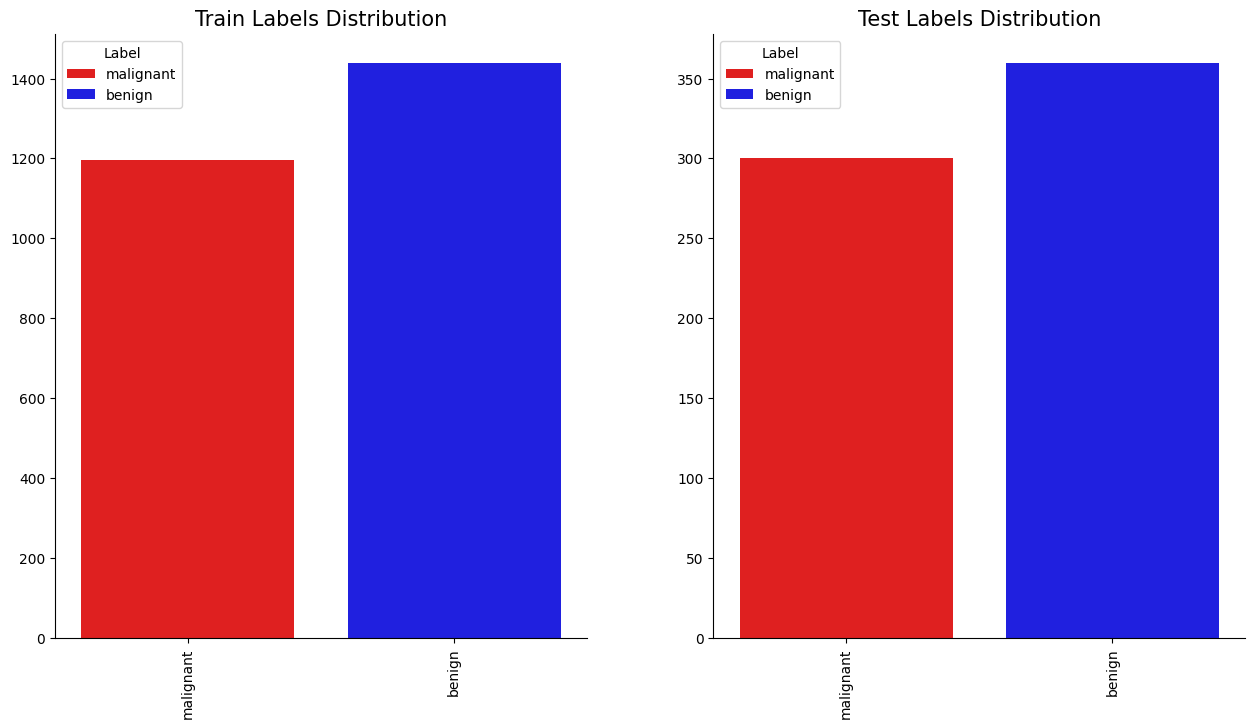

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))  # Changed to 1 row and 2 columns

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Create a dictionary to map categories to colors
color_mapping = {'malignant': 'red', 'benign': 'blue'}

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=15)

# Plot each category with its specific color
for category, color in color_mapping.items():
    # Filter the data for the category
    cat_data = train_class_count.get(category, 0)
    sns.barplot(x=[category], y=[cat_data], color=color, ax=ax1, label=category)

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=15)

# Plot each category with its specific color
for category, color in color_mapping.items():
    # Filter the data for the category
    cat_data = test_class_count.get(category, 0)
    sns.barplot(x=[category], y=[cat_data], color=color, ax=ax2, label=category)

# To prevent the labels from overlapping with the plots
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

# Add legend
ax1.legend(title="Label")
ax2.legend(title="Label")

sns.despine()

plt.show()

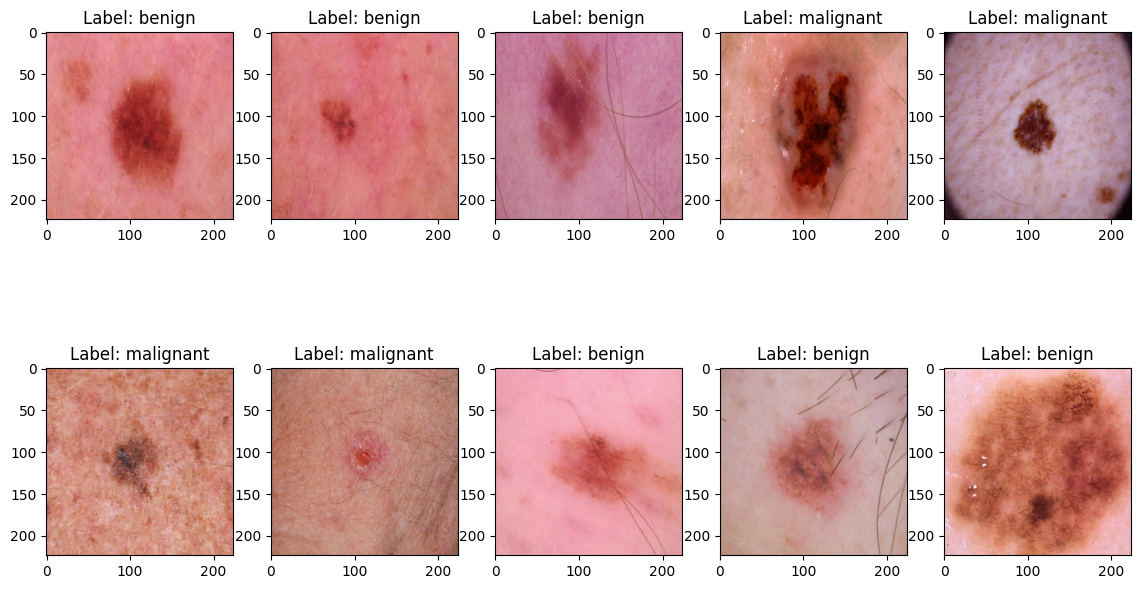

In [ ]:
# View sample training images from both the classes
def load_image(image_path):

    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    # Resize image
    image = tf.image.resize(image, [224, 224],
                            method = tf.image.ResizeMethod.LANCZOS3)

    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.

    # Return image
    return image

idx = random.sample(train_df.index.to_list(), 10)
fig = plt.figure(figsize=(14,8))

for id, _ in enumerate(idx):

    plt.subplot(2, 5, id+1)
    plt.title(f'Label: {train_df.label[_]}')
    plt.imshow(load_image(train_df.image_path[_]))

### Pre-processing data

This code performes few pre-processing steps on training & testing data like:
- split training into train-validation split
- add custom augmengtation layer(can be replaced with ImageDataGenerator) - here data is preety much balanced already so no need to do higher augmentation, only randomflip & randomzoom is performed.
- prepare tensor dataset and batches using tensorfloe.data.Dataset to fit in the training data


In [ ]:
# Split the training data into train-validation set
train_idx, val_ind, _, _ = train_test_split(train_df.index, train_df.label_encoded, test_size = 0.20,
                                            stratify = train_df.label_encoded, random_state = 42)

# Get training and validation data
train_new_df = train_df.iloc[train_idx].reset_index(drop=True)
val_df = train_df.iloc[val_ind].reset_index(drop=True)

# View shapes
print(f"training size: {train_new_df.shape}, validation size: {val_df.shape}")

training size: (2109, 3), validation size: (528, 3)


In [ ]:
# Check class balance in both trainng and validation set
train_class_count = train_new_df['label'].value_counts()
val_class_count = val_df['label'].value_counts()

print(f"train_class_count: {train_class_count}")
print(f"test_class_count: {val_class_count}")

train_class_count: label
benign       1152
malignant     957
Name: count, dtype: int64
test_class_count: label
benign       288
malignant    240
Name: count, dtype: int64


In [ ]:
# Build custome augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed = 42),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed = 42),
], name='augmentation_layer')

In [ ]:
# Define function to build tensor batched dataset
def pre_processing(orig_df, augmentation = False):

    # Get image paths and labels from DataFrame
    image_paths = orig_df.image_path
    image_labels = tf.one_hot(orig_df.label_encoded, depth = 2).numpy()

    # create tensor dataset from original data
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    # apply augmentation layer to the data
    if augmentation:
          dataset = dataset.map(lambda x, y: (augmentation_layer(load_image(x)), y), num_parallel_calls = tf.data.AUTOTUNE)
    else:
          dataset = dataset.map(lambda x, y: (load_image(x), y), num_parallel_calls = tf.data.AUTOTUNE)

    # apply batching
    dataset = dataset.batch(32)

    return dataset

In [ ]:
# Generate tensor datasets for train, validation(no augmentation) and test(no augmentation)
train_dataset = pre_processing(train_new_df, augmentation = True)

val_dataset = pre_processing(val_df)

test_dataset = pre_processing(test_df)

In [ ]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

### Vision Transformer

This code builds and train Transfer Learning-enhanced version of Vision Transformer(ViT) model from vit-keras, check validation and test accuracy and other performance parameters

In [ ]:
# Load the Vision Transformer Model model
vit_model_16 = vit.vit_b16(image_size = 224, activation = 'sigmoid', pretrained = True, include_top = False, pretrained_top = False, classes = 2)

# Freeze model layers for inference-mode only
for layer in vit_model_16.layers:
    layer.trainable = False

347502902/347502902 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
# Define Efficient V2 model
def vit_b16_model():

    vit_model_sequential = Sequential([
        layers.Input(shape = (224, 224, 3), dtype = tf.float32, name = 'input_image'),
        vit_model_16,
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, dtype=tf.float32, activation='sigmoid')], name='vit_b16_sequential_model')

    tf.random.set_seed(42)

    # Compile the model
    vit_model_sequential.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                                  metrics = "accuracy")

    return vit_model_sequential

In [ ]:
# initialize model
vit_model = vit_b16_model()

print(vit_model.summary())

Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 85897346 (327.67 MB)
Trainable params: 98690 (385.51 KB)
Non-trainable params: 85798656 (327.30 MB)
_________________________________________________________________
None


In [ ]:
# train model with training data
vit_training = vit_model.fit(train_dataset, epochs = 50, validation_data = val_dataset, validation_steps = int(len(val_dataset)),
                             callbacks = early_stopping)

Epoch 1/50
66/66 [==============================] - 519s 7s/step - loss: 0.4327 - accuracy: 0.7975 - val_loss: 0.3112 - val_accuracy: 0.8674
Epoch 2/50
66/66 [==============================] - 42s 637ms/step - loss: 0.3252 - accuracy: 0.8549 - val_loss: 0.2838 - val_accuracy: 0.8712
Epoch 3/50
66/66 [==============================] - 41s 627ms/step - loss: 0.3201 - accuracy: 0.8559 - val_loss: 0.2935 - val_accuracy: 0.8598
Epoch 4/50
66/66 [==============================] - 42s 627ms/step - loss: 0.2967 - accuracy: 0.8634 - val_loss: 0.2915 - val_accuracy: 0.8769
Epoch 5/50
66/66 [==============================] - 41s 625ms/step - loss: 0.2895 - accuracy: 0.8663 - val_loss: 0.2942 - val_accuracy: 0.8712
Epoch 6/50
66/66 [==============================] - 42s 629ms/step - loss: 0.2742 - accuracy: 0.8777 - val_loss: 0.2779 - val_accuracy: 0.8598
Epoch 7/50
66/66 [==============================] - 41s 625ms/step - loss: 0.2642 - accuracy: 0.8767 - val_loss: 0.2849 - val_accuracy: 0.8693
E

In [ ]:
# Evaluate the model on test dataframe
vit_evaluation = vit_model.evaluate(test_dataset)

21/21 [==============================] - 242s 11s/step - loss: 0.3034 - accuracy: 0.8576


In [ ]:
# Generate model probabilities and associated predictions
vit_test_prob = vit_model.predict(test_dataset, verbose=1)
vit_test_pred = tf.argmax(vit_test_prob, axis=1)

21/21 [==============================] - 12s 421ms/step


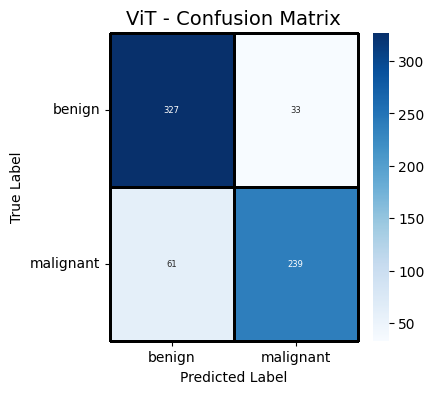

In [ ]:
# generate & plot confusion matrics to check False positives & False negatuves
vit_confusion_matrix = confusion_matrix(test_df.label_encoded, vit_test_pred)

# Set plot size
plt1 = plt.figure(figsize = (4, 4))

# Create confusion matrix heatmap
disp = sns.heatmap(vit_confusion_matrix, annot = True, cmap = 'Blues',
                   annot_kws={"size": 6}, fmt='g',
                   linewidths=1, linecolor='black', clip_on=False,
                   xticklabels = ['benign', 'malignant'], yticklabels = ['benign', 'malignant'])

# Set title and axis labels
disp.set_title('ViT - Confusion Matrix', fontsize = 14)
disp.set_xlabel('Predicted Label', fontsize = 10)
disp.set_ylabel('True Label', fontsize = 10)
plt.yticks(rotation=0)

# Plot confusion matrix
plt1.savefig("/content/drive/MyDrive/Colab Notebooks/8013/ViT_CM.pdf")
plt1.show()

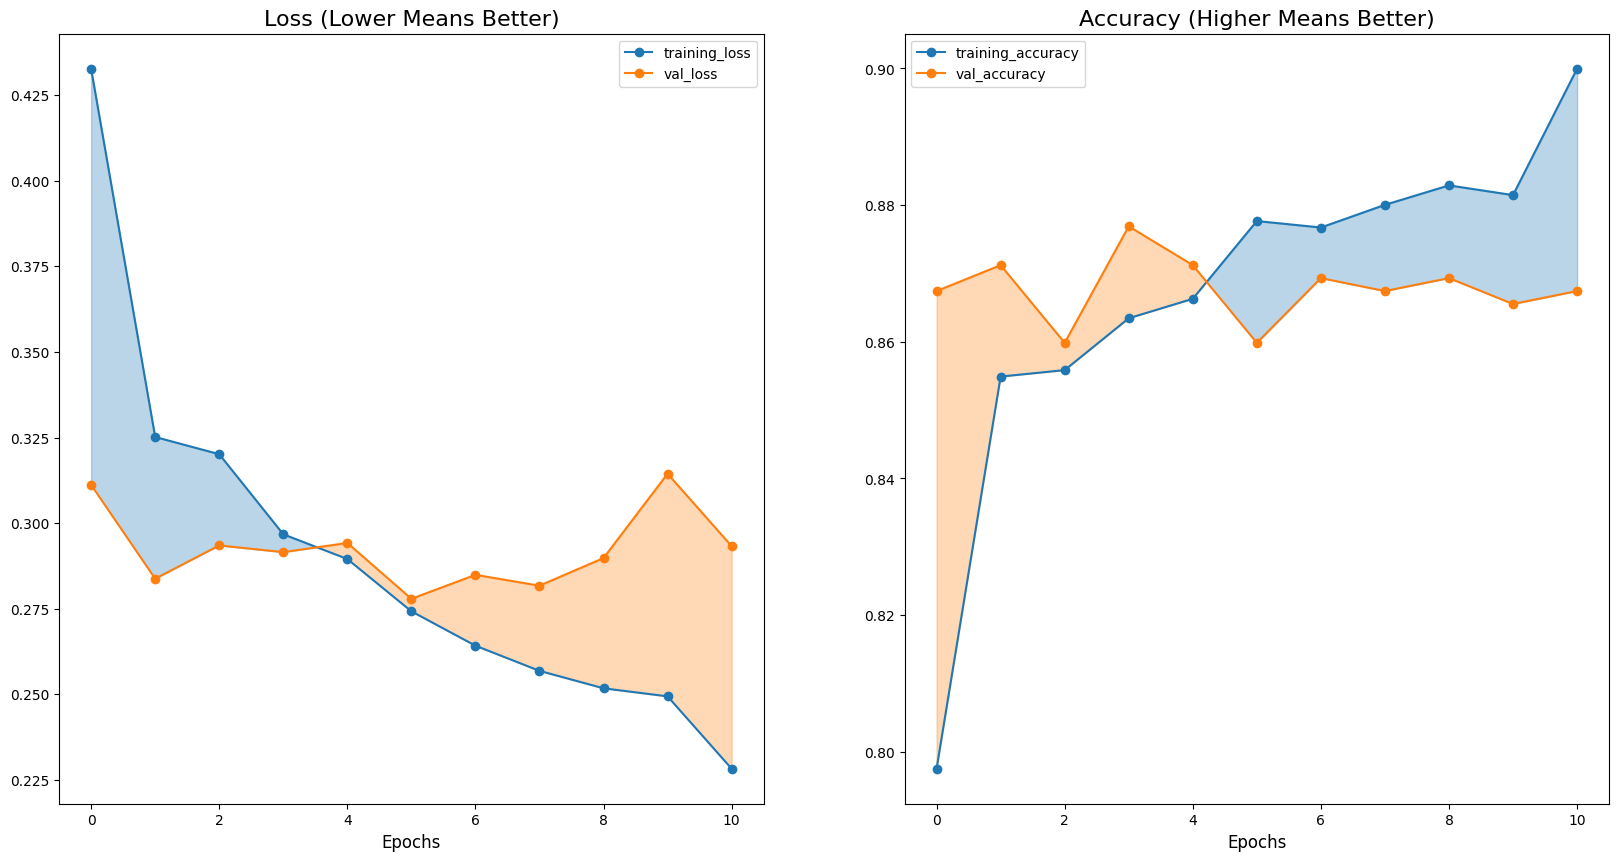

In [ ]:
# Ploting train - validation Accuracy and loss curves and ROC curve
train_loss = np.array(vit_training.history['loss'])
val_loss = np.array(vit_training.history['val_loss'])

train_accuracy = np.array(vit_training.history['accuracy'])
val_accuracy = np.array(vit_training.history['val_accuracy'])

epochs = range(len(vit_training.history['loss']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot loss
ax1.plot(epochs, train_loss, label='training_loss', marker='o')
ax1.plot(epochs, val_loss, label='val_loss', marker='o')

ax1.fill_between(epochs, train_loss, val_loss, where=(train_loss > val_loss), color='C0', alpha=0.3, interpolate=True)
ax1.fill_between(epochs, train_loss, val_loss, where=(train_loss < val_loss), color='C1', alpha=0.3, interpolate=True)

ax1.set_title('Loss (Lower Means Better)', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.legend()

# Plot accuracy
ax2.plot(epochs, train_accuracy, label='training_accuracy', marker='o')
ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

ax2.fill_between(epochs, train_accuracy, val_accuracy, where=(train_accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
ax2.fill_between(epochs, train_accuracy, val_accuracy, where=(train_accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.legend();

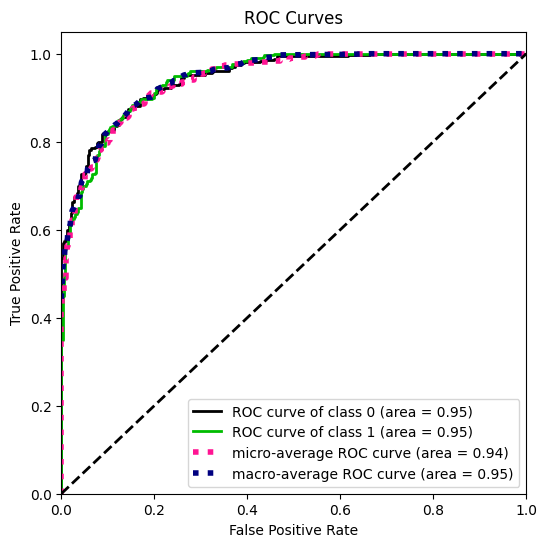

In [ ]:
# plot roc curve
plt2 = plot_roc(test_df.label_encoded, vit_test_prob, figsize=(6, 6), title_fontsize='large')
plt2.figure.savefig("/content/drive/MyDrive/Colab Notebooks/8013/ViT_ROC.pdf")

In [ ]:
# ViT classification report
print(classification_report(test_df.label_encoded,
                            vit_test_pred,
                            target_names=["Benign", "Malignant"]))

              precision    recall  f1-score   support

      Benign       0.84      0.91      0.87       360
   Malignant       0.88      0.80      0.84       300

    accuracy                           0.86       660
   macro avg       0.86      0.85      0.85       660
weighted avg       0.86      0.86      0.86       660



## XAI

### LIME

In [ ]:
# Sample 5 from each class
class0 = test_df[test_df['label_encoded'] == 0].sample(5, random_state = 10)
class1 = test_df[test_df['label_encoded'] == 1].sample(5, random_state = 10)
sampled_df = pd.concat([class0, class1])

# Create dataset from the sampled DataFrame
sampled_dataset = pre_processing(sampled_df, augmentation=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 94ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 68ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 61ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 55ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 64ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 61ms/step


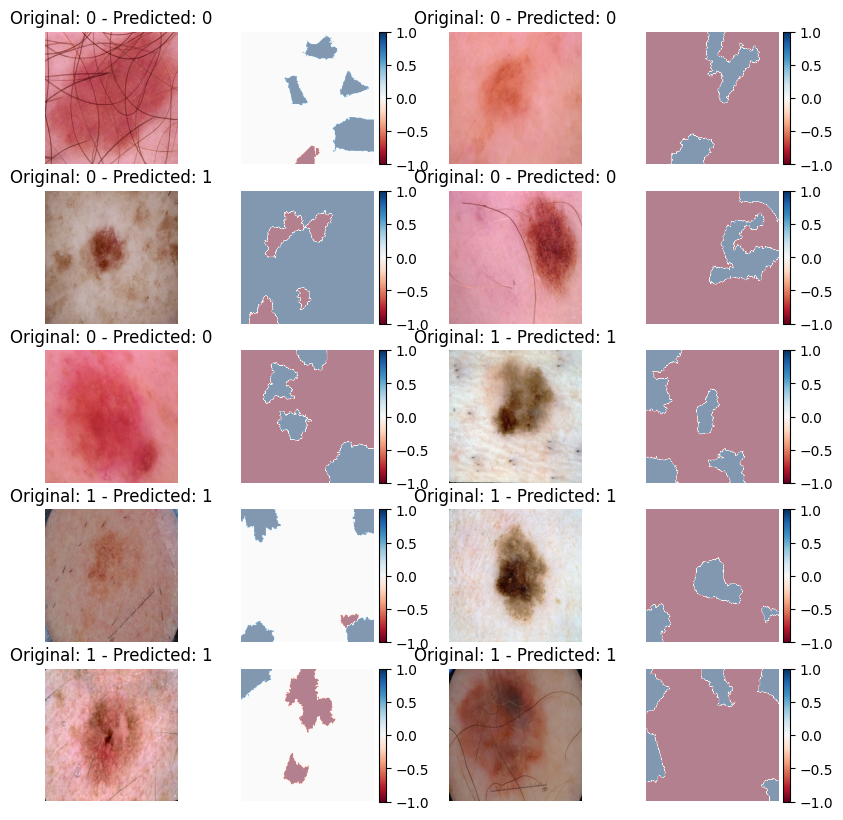

In [ ]:
# Initialize the LIME Image Explainer
explainer = lime_image.LimeImageExplainer(verbose = False)

# Function to predict model on batches for LIME
def predict_fn(images):
    return vit_model.predict(images)

# Prepare figure for plotting
# fig, axs = plt.subplots(10, 2, figsize=(10, 40))
fig1, axs = plt.subplots(5, 4, figsize=(10, 10))  # Adjusted size for better display

# Process each image in the sampled dataset
for i, (images, labels) in enumerate(sampled_dataset.unbatch().take(10)):
    row = i // 2  # Each row contains pairs of image and heatmap
    col = (i % 2) * 2  # Calculate column index, alternating between starting points 0 and 2
    img = images.numpy()  # Convert TensorFlow tensor to numpy array
    img_batch = tf.expand_dims(images, axis=0).numpy()  # Add batch dimension for model prediction

    # Generate LIME explanation
    explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

    # Get image and mask for the top prediction
    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(top_label, positive_only=False, num_features=5, hide_rest=False)

    axs[row, col].imshow(images.numpy())
    true_label = np.argmax(labels.numpy())
    pred = vit_model.predict(img_batch)
    predicted_label = np.argmax(pred[0])
    axs[row, col].title.set_text(f'Original: {true_label} - Predicted: {predicted_label}')
    axs[row, col].axis('off')

    axs[row, col+1].imshow(mask,  cmap='RdBu', alpha=0.5)
    axs[row, col+1].axis('off')

    # Add colorbar to explain the heatmap intensity
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(axs[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    mappable = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-1, vmax=1))
    cbar = plt.colorbar(mappable, cax=cax, orientation='vertical')

fig1.savefig("/content/drive/MyDrive/Colab Notebooks/8013/ViT_LIME.pdf")
# fig1.savefig("ViT_LIME.pdf")
plt.show()

### Attention mapping

In [ ]:
def build_attention_model(base_model):
    # Define the input exactly like the base model's input
    input_layer = base_model.input

    # Define the outputs: the original model's output and attention weights from a chosen transformer block
    # We select the last block's attention weights for visualization
    final_output = base_model.output
    attention_weights = base_model.get_layer("Transformer/encoderblock_11").output[1]

    # Create a new model that outputs both the final predictions and the attention weights
    model_with_attention = Model(inputs=input_layer, outputs=[final_output, attention_weights])
    return model_with_attention

# Assuming 'vit_model' is your pre-loaded Vision Transformer model
vit_attention_model = build_attention_model(vit_model_16)

#### Attentions after first transformer block

1/1 [==============================] - 4s 4s/step


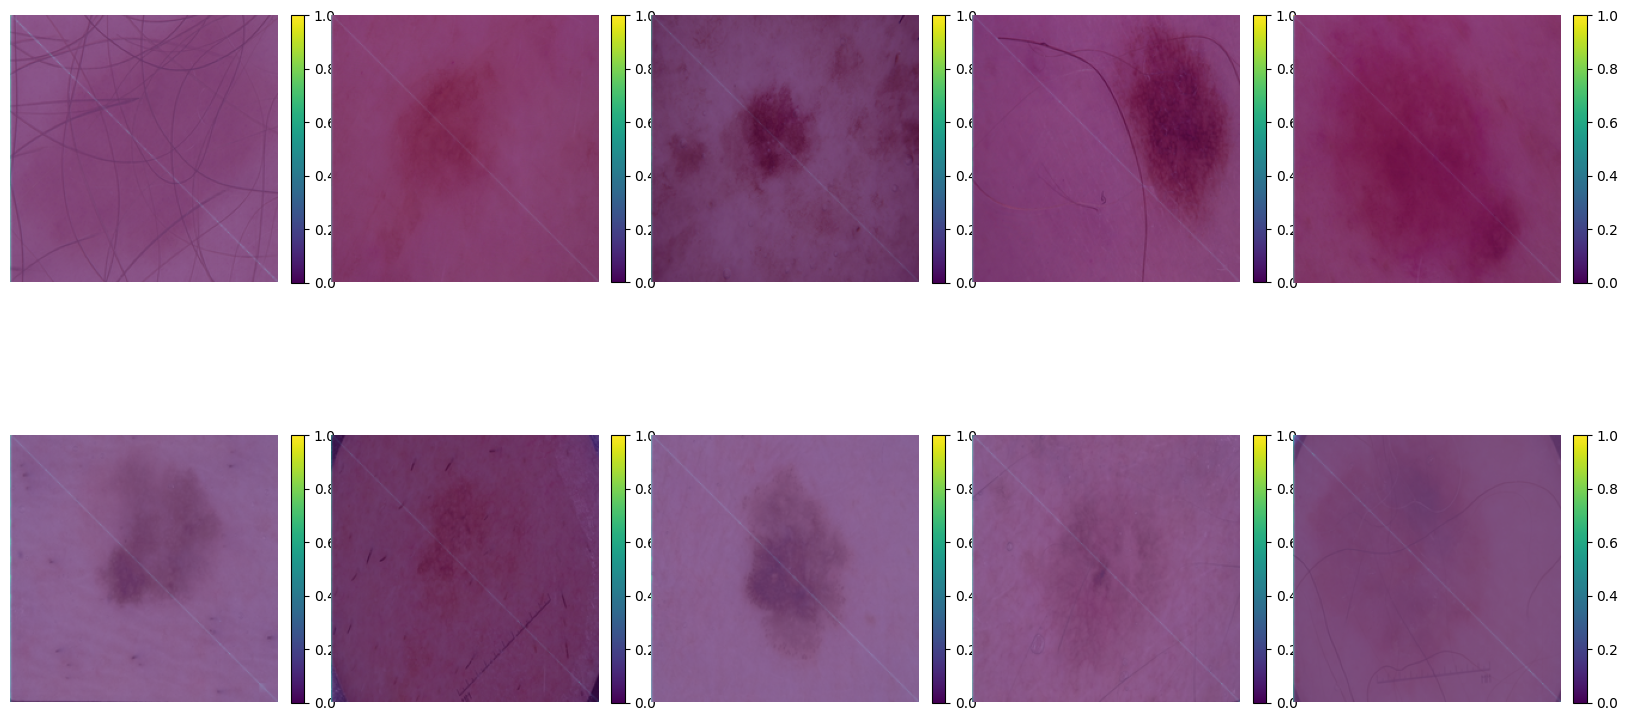

In [ ]:
for images, labels in sampled_dataset.take(1):  # Process the first batch
    input_images = images.numpy()  

    # Predict and extract attention weights
    final_predictions, attention_weights = vit_attention_model.predict(input_images)

    fig2, axs = plt.subplots(2, 5, figsize=(20, 10))

    # Loop through each image in the batch
    for i in range(input_images.shape[0]):
        # Prepare the original image, normalize if needed
        original_image = input_images[i]
        if original_image.min() < 0 or original_image.max() > 1:
            original_image = (original_image + 1) / 2  # Normalize to [0, 1] if needed
        original_image = np.clip(original_image, 0, 1)  # Ensure values are within [0, 1]


        # Normalize the attention map
        attention_map = np.mean(attention_weights[i], axis=0)  # Average across all heads
        attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))

        # Resize the attention map to match the original image size
        height, width, _ = original_image.shape
        attention_map_resized = resize(attention_map, (height, width), mode='reflect', anti_aliasing=True)

        # Create heatmap
        heatmap = np.uint8(255 * attention_map_resized)  # Convert to uint8
        heatmap = plt.cm.viridis(heatmap)[:, :, :3]  # Apply colormap by cutting off alpha channel

        # Overlay the heatmap onto the original image
        alpha = 0.6  # Define the transparency level
        overlayed_image = heatmap * alpha + original_image * (1 - alpha)

        row = i // 5
        col = i % 5
        ax = axs[row, col]
        im = ax.imshow(overlayed_image)
        ax.axis('off')  # Hide axes

        # Create a colorbar with the correct scale
        axins = ax.inset_axes([1.05, 0, 0.05, 1], transform=ax.transAxes)  
        mappable = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
        mappable.set_array([])
        cbar = plt.colorbar(mappable, cax=axins)

    fig2.savefig("/content/drive/MyDrive/Colab Notebooks/8013/ViT_Attentions_0.pdf")
    plt.show()

#### Attentions after five transformer blocks

1/1 [==============================] - 4s 4s/step


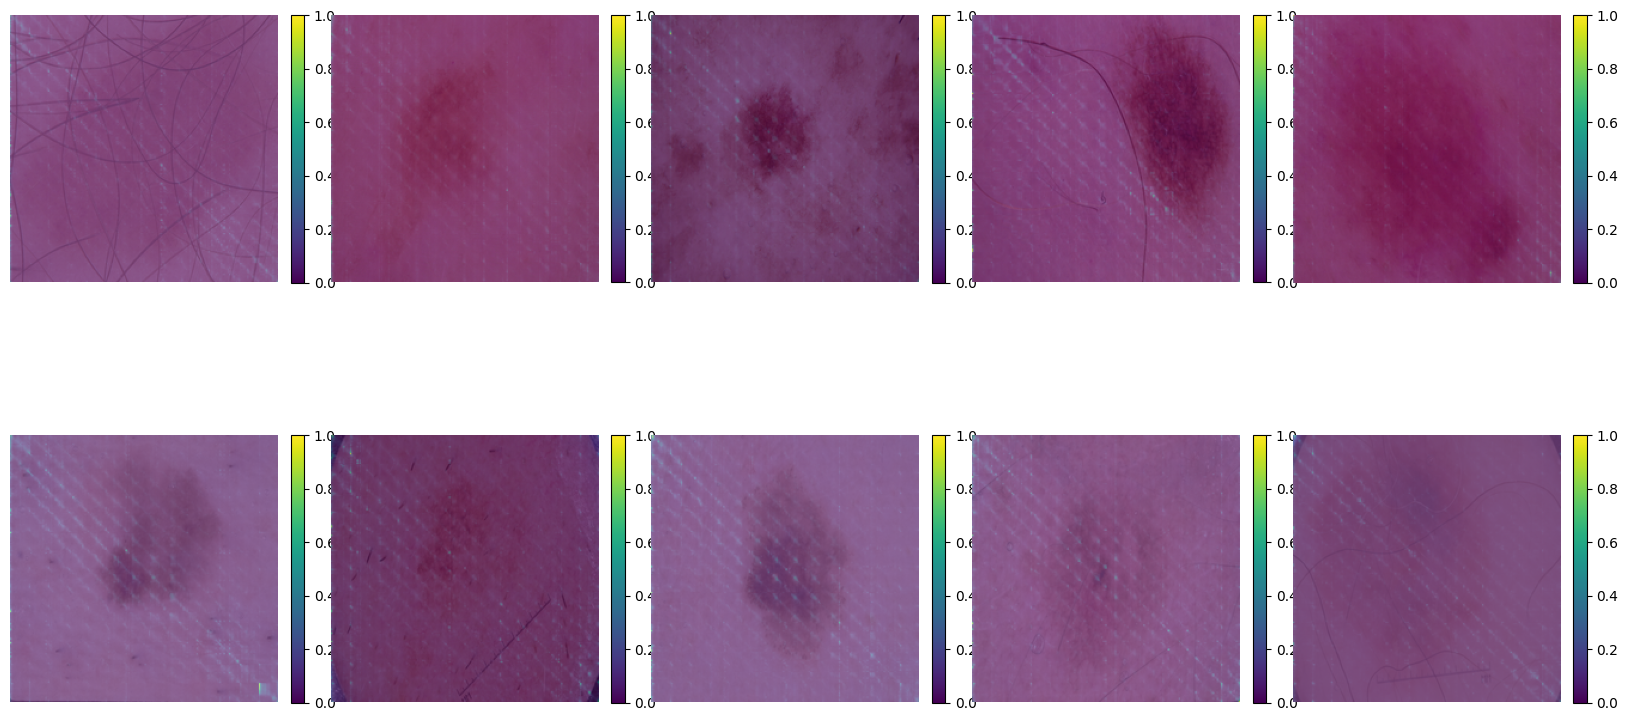

In [ ]:
for images, labels in sampled_dataset.take(1):  # Process the first batch
    input_images = images.numpy()  

    # Predict and extract attention weights
    final_predictions, attention_weights = vit_attention_model.predict(input_images)

    fig2, axs = plt.subplots(2, 5, figsize=(20, 10))

    # Loop through each image in the batch
    for i in range(input_images.shape[0]):
        # Prepare the original image, normalize if needed
        original_image = input_images[i]
        if original_image.min() < 0 or original_image.max() > 1:
            original_image = (original_image + 1) / 2  # Normalize to [0, 1] if needed
        original_image = np.clip(original_image, 0, 1)  # Ensure values are within [0, 1]


        # Normalize the attention map
        attention_map = np.mean(attention_weights[i], axis=0)  # Average across all heads
        attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))

        # Resize the attention map to match the original image size
        height, width, _ = original_image.shape
        attention_map_resized = resize(attention_map, (height, width), mode='reflect', anti_aliasing=True)

        # Create heatmap
        heatmap = np.uint8(255 * attention_map_resized)  # Convert to uint8
        heatmap = plt.cm.viridis(heatmap)[:, :, :3]  # Apply colormap by cutting off alpha channel

        # Overlay the heatmap onto the original image
        alpha = 0.6  # Define the transparency level
        overlayed_image = heatmap * alpha + original_image * (1 - alpha)

        row = i // 5
        col = i % 5
        ax = axs[row, col]
        im = ax.imshow(overlayed_image)
        ax.axis('off')  # Hide axes

        # Create a colorbar with the correct scale
        axins = ax.inset_axes([1.05, 0, 0.05, 1], transform=ax.transAxes)  
        mappable = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
        mappable.set_array([])
        cbar = plt.colorbar(mappable, cax=axins)

    fig2.savefig("/content/drive/MyDrive/Colab Notebooks/8013/ViT_Attentions_5.pdf")
    plt.show()

#### Attentions at final transformer block

1/1 [==============================] - 6s 6s/step


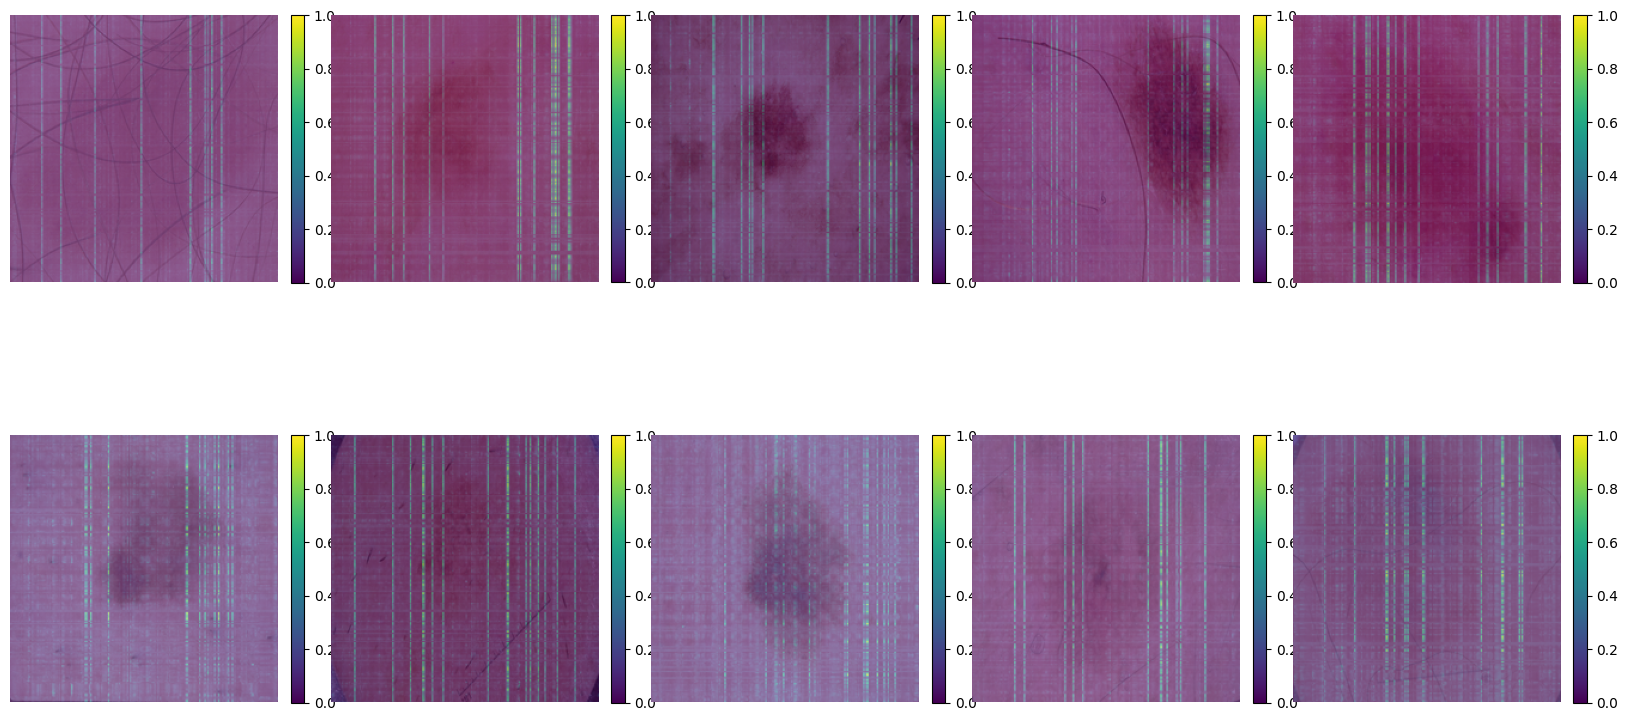

In [ ]:
for images, labels in sampled_dataset.take(1):  # Process the first batch
    input_images = images.numpy()  

    # Predict and extract attention weights
    final_predictions, attention_weights = vit_attention_model.predict(input_images)

    fig2, axs = plt.subplots(2, 5, figsize=(20, 10))

    # Loop through each image in the batch
    for i in range(input_images.shape[0]):
        # Prepare the original image, normalize if needed
        original_image = input_images[i]
        if original_image.min() < 0 or original_image.max() > 1:
            original_image = (original_image + 1) / 2  # Normalize to [0, 1] if needed
        original_image = np.clip(original_image, 0, 1)  # Ensure values are within [0, 1]


        # Normalize the attention map
        attention_map = np.mean(attention_weights[i], axis=0)  # Average across all heads
        attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))

        # Resize the attention map to match the original image size
        height, width, _ = original_image.shape
        attention_map_resized = resize(attention_map, (height, width), mode='reflect', anti_aliasing=True)

        # Create heatmap
        heatmap = np.uint8(255 * attention_map_resized)  # Convert to uint8
        heatmap = plt.cm.viridis(heatmap)[:, :, :3]  # Apply colormap by cutting off alpha channel

        # Overlay the heatmap onto the original image
        alpha = 0.6  # Define the transparency level
        overlayed_image = heatmap * alpha + original_image * (1 - alpha)

        row = i // 5
        col = i % 5
        ax = axs[row, col]
        im = ax.imshow(overlayed_image)
        ax.axis('off')  # Hide axes

        # Create a colorbar with the correct scale
        axins = ax.inset_axes([1.05, 0, 0.05, 1], transform=ax.transAxes) 
        mappable = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
        mappable.set_array([])
        cbar = plt.colorbar(mappable, cax=axins)

    fig2.savefig("/content/drive/MyDrive/Colab Notebooks/8013/ViT_Attentions_final.pdf")
    plt.show()